In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()
sc = spark.sparkContext

24/12/22 19:31:26 WARN Utils: Your hostname, wangbodeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.64.90.31 instead (on interface en0)
24/12/22 19:31:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/22 19:31:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [17]:
rdd = sc.wholeTextFiles('./tiny_files')
rdd.map(lambda x:x[1]).flatMap(lambda x: x.split(' '))\
    .flatMap(lambda x: x.split('\r\n')).map(lambda x:(x,1))\
    .reduceByKey(lambda a,b:a+b).collect()

[('hello', 15), ('hadoop', 5), ('spark', 5), ('flink', 5)]

# filter

In [21]:
rdd = sc.parallelize([1,2,3,4,5,6,7])
rdd.filter(lambda x: x%2==1).collect()

[1, 3, 5, 7]

# distinct

In [18]:
rdd = sc.parallelize([1,1,1,1,1,2,2,2])
rdd.distinct().collect()

[1, 2]

# join
默认以2元组的key进行关联

In [20]:
rdd1 = sc.parallelize([(1001,'a'),(1002,'b'),(1003,'c')])
rdd2 = sc.parallelize([(1001,'科技'),(1002,'销售')])
rdd1.leftOuterJoin(rdd2).collect()

[(1001, ('a', '科技')), (1002, ('b', '销售')), (1003, ('c', None))]

# glom
将rdd数据加上嵌套（每个分区变成一个嵌套）

In [23]:
rdd = sc.parallelize([1,2,3,4,5,6,7,8,9],4)
rdd.glom().flatMap(lambda x:x).collect()

[1, 2, 3, 4, 5, 6, 7, 8, 9]

# groupby vs groupbykey

In [24]:
rdd = sc.parallelize([('a',1),('a',2),('a',3),('b',1),('b',2)])

In [25]:
# groupby
rdd.groupBy(lambda x:x[0]).map(lambda x:(x[0],list(x[1]))).collect()

[('a', [('a', 1), ('a', 2), ('a', 3)]), ('b', [('b', 1), ('b', 2)])]

In [26]:
# groupbykey
rdd.groupByKey().map(lambda x:(x[0],list(x[1]))).collect()

[('a', [1, 2, 3]), ('b', [1, 2])]

# sortby vs sortbykey

In [ ]:
rdd = sc.parallelize([('a',1),('a',2),('a',5),('b',7),('b',0)])
# 全局有序需要numPartitions=1
rdd.sortBy(lambda x:x[1],ascending=True,numPartitions=1).collect()

[('b', 0), ('a', 1), ('a', 2), ('a', 5), ('b', 7)]

In [34]:
rdd.map(lambda x:(x[1],x[0])).sortByKey(ascending=True,numPartitions=1,keyfunc=lambda x:-1*x).collect()

[(7, 'b'), (5, 'a'), (2, 'a'), (1, 'a'), (0, 'b')]

# 案例1

In [41]:
import json
rdd = sc.textFile('./测试数据/order.text')
rdd.flatMap(lambda x: x.split('|'))\
    .map(lambda x: json.loads(x))\
        .filter(lambda x: (x['areaName'] == '北京') or (x['areaName'] == '杭州'))\
            .map(lambda x:(x['areaName'],x['category'])).distinct().collect()

[('北京', '家电'),
 ('杭州', '电脑'),
 ('北京', '电脑'),
 ('北京', '食品'),
 ('北京', '平板电脑'),
 ('北京', '手机'),
 ('北京', '家具'),
 ('杭州', '家具'),
 ('北京', '书籍'),
 ('杭州', '服饰'),
 ('北京', '服饰')]

依赖文件要提交到集群中
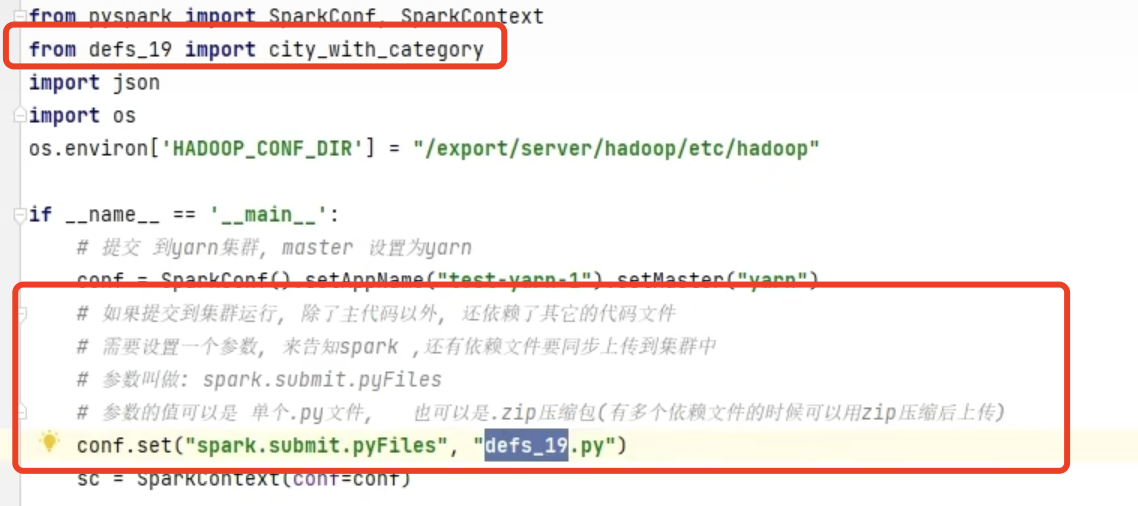

# fold
分区内聚合和分区间聚合都会加入初始值

In [43]:
rdd = sc.parallelize(list(range(1,10)),3)
rdd.fold(10,lambda a,b:a+b)

85

# takeSample

In [48]:
rdd = sc.parallelize(list(range(1,10)),3)
rdd.takeSample(True,20)

[9, 8, 7, 5, 5, 7, 9, 3, 1, 9, 8, 3, 9, 1, 9, 3, 3, 2, 6, 2]

# takeOrdered

In [52]:
rdd = sc.parallelize(list(range(1,10)))
rdd.takeOrdered(3,lambda x:-x)

[9, 8, 7]

# foreach
foreach是没有返回值的map，同时foreach是由executor执行的，不是由driver执行的，不用向driver回报，适用于不需要返回值的场景，比如将数据插入数据库，这样可以利用executor多线程完成了

# saveAsTextFile
保存数据，可以多文件保存，根据分区数确定（也是由executor执行的）

# mapPartition
相对于map而言，传参形式不同了，将一个分区作为一个迭代器作为参数传给函数（减少了网络传输参数）【性能提升】

In [54]:
def fun(l):
    return [i*10 for i in l]
rdd = sc.parallelize(list(range(10)),3)
rdd.mapPartitions(lambda x: fun(x)).collect()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

# foreachPartition
相对于foreach而言，传参形式不同了，将一个分区作为一个迭代器作为参数传给函数（减少了网络传输参数）【性能提升】

In [56]:
def fun(l):
    print([i*10 for i in l])
rdd = sc.parallelize(list(range(10)),3)
rdd.foreachPartition(lambda x: fun(x))

[60, 70, 80, 90]
[30, 40, 50]
[0, 10, 20]


# partitionby
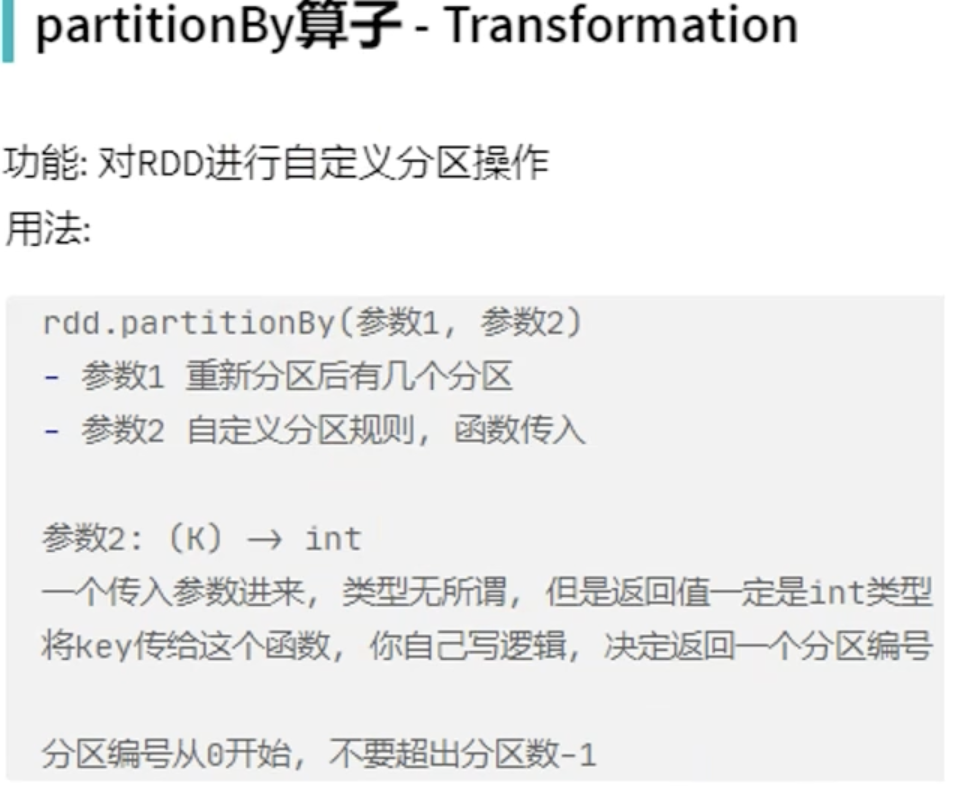

In [57]:
rdd = sc.parallelize([('hadoop',1),('hello',1),('spark',1),('hadoop',2),('flink',1)])
def process(k):
    if (k == 'hadoop') or (k == 'hello'): return 0
    if k == 'spark': return 1
    if k == 'flink': return 2
rdd.partitionBy(3,process).glom().collect()

[[('hadoop', 1), ('hello', 1), ('hadoop', 2)], [('spark', 1)], [('flink', 1)]]

# repartition
coalesce和repartition差不多，但是对于分区增多的操作有安全机制，需要显式指定允许shuffle
要么不用，要么减少分区
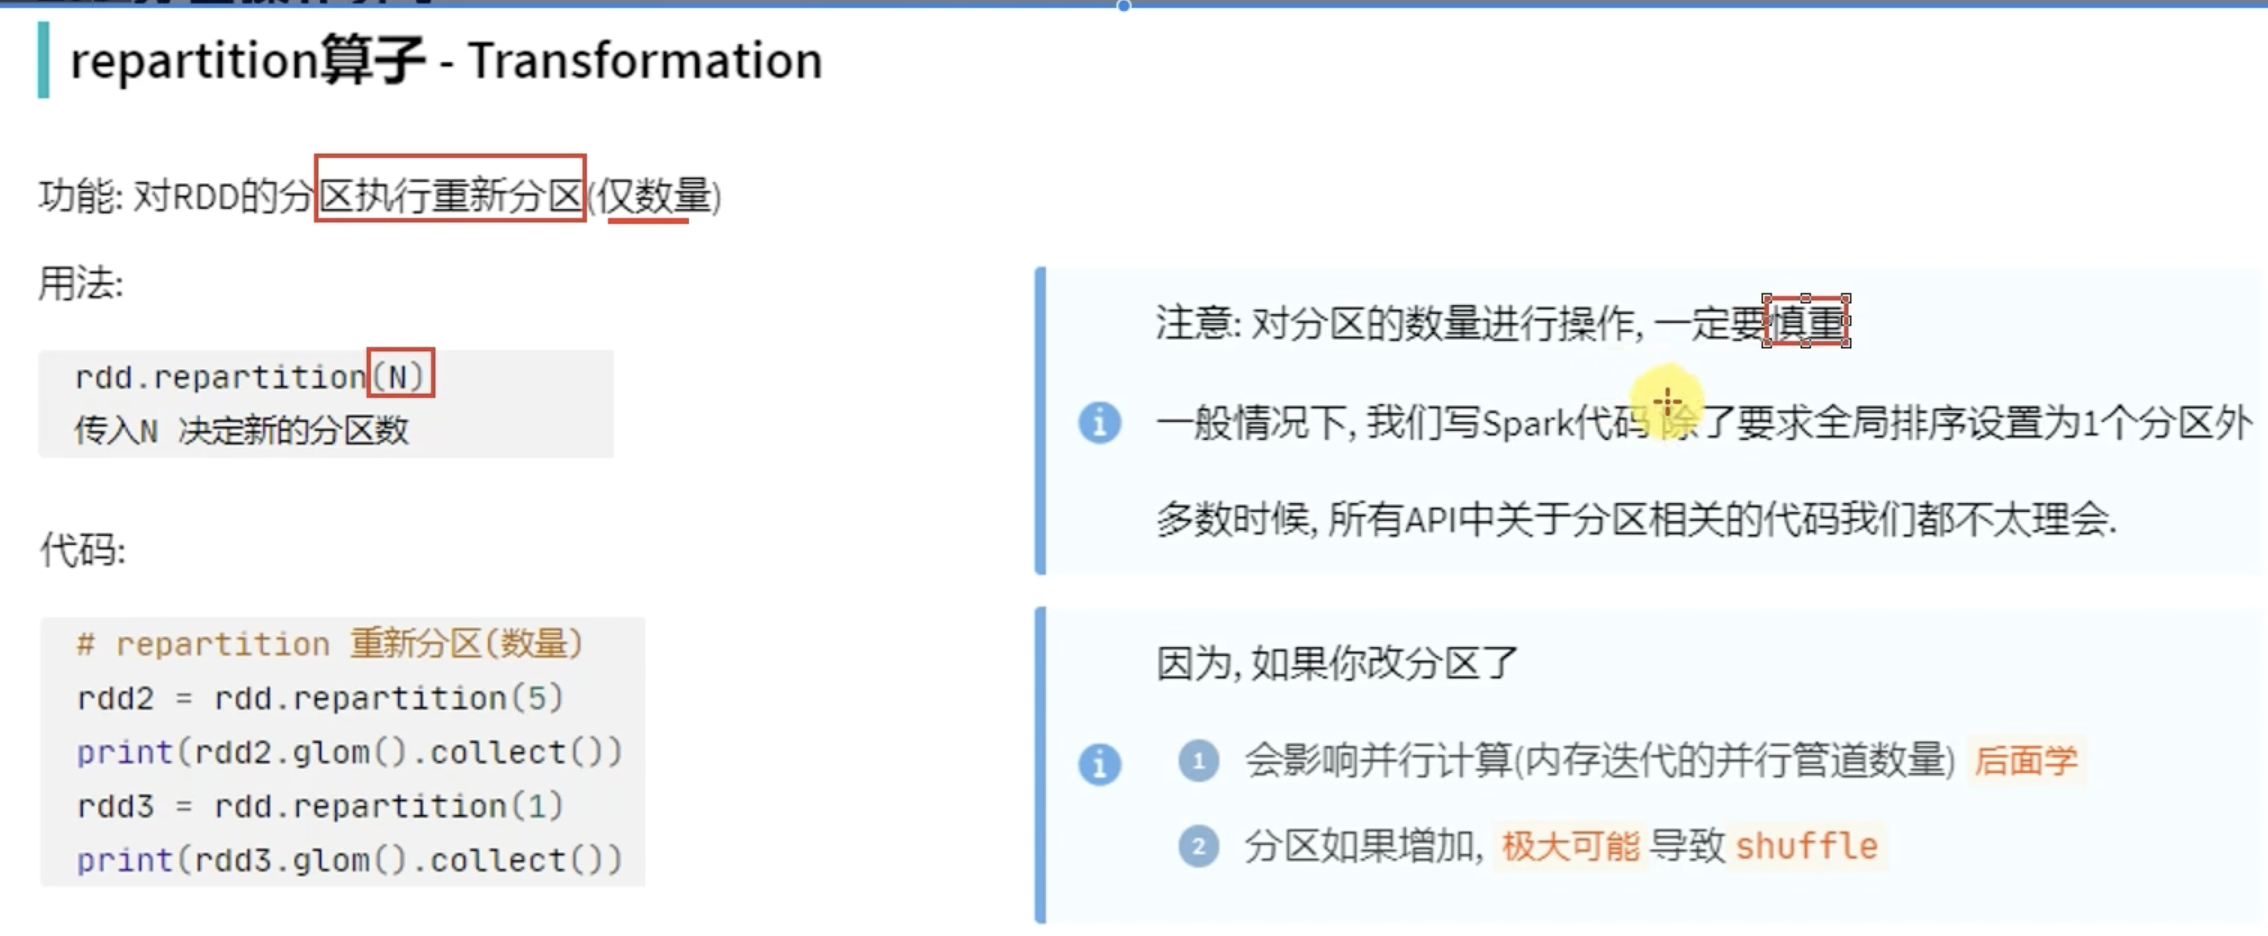

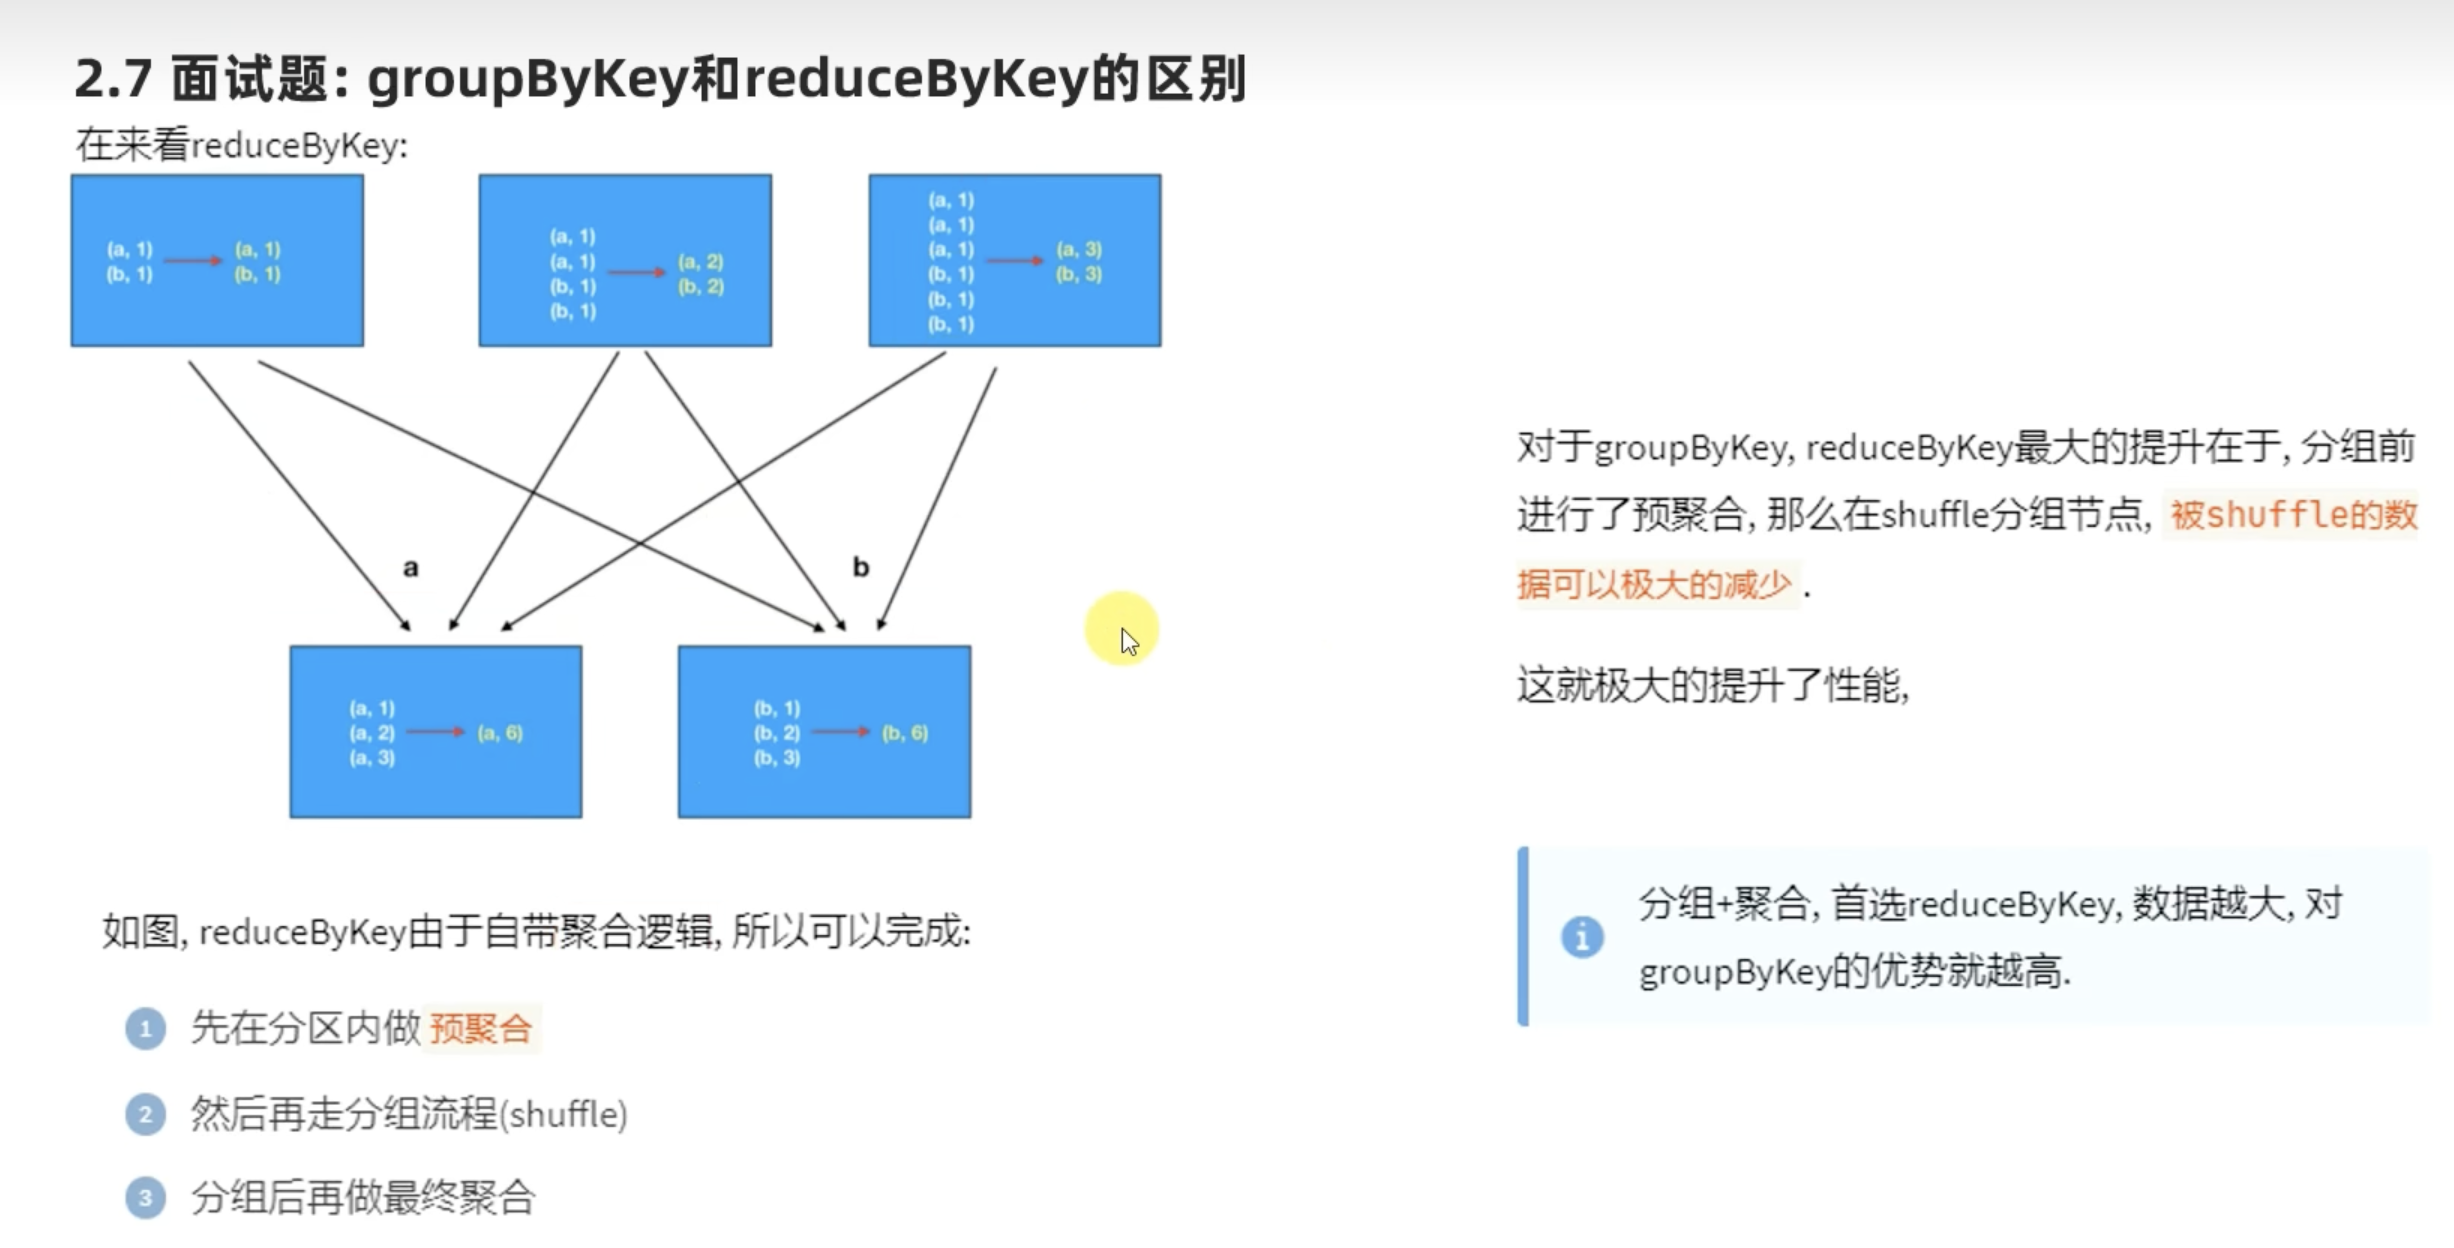

# 广播变量
减少网络io和避免不必要的变量广播导致内存浪费

In [2]:
stu_list = [(1,'张',11),
            (2,'王',22),
            (3,'李',33)]

rdd = sc.parallelize([(1,'数',99),
                      (2,'数',99),
                      (3,'数',99),
                      (1,'英语',99),
                      (2,'英语',99),
                      (3,'英语',99),
                      (1,'语文',99)])
broadcast = sc.broadcast(stu_list)

def fun(data):
    id = data[0]
    for i in broadcast.value:
        if id == i[0]:
            return (i[1],data[1],data[2])
    return ('',data[1],data[2])

rdd.map(fun).collect()

[('张', '数', 99),
 ('王', '数', 99),
 ('李', '数', 99),
 ('张', '英语', 99),
 ('王', '英语', 99),
 ('李', '英语', 99),
 ('张', '语文', 99)]

24/12/22 23:00:49 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 566415 ms exceeds timeout 120000 ms
24/12/22 23:00:49 WARN SparkContext: Killing executors is not supported by current scheduler.
24/12/22 23:00:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

# sparksql

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    master('local[*]').\
        appName('test').\
            getOrCreate()

sc = spark.sparkContext

24/12/23 13:37:34 WARN Utils: Your hostname, wangbodeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.64.90.31 instead (on interface en0)
24/12/23 13:37:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/23 13:37:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.format("json").load('./测试数据/categories.json')

In [3]:
df.printSchema()

root
 |-- category: string (nullable = true)
 |-- id: long (nullable = true)
 |-- super-category: string (nullable = true)

